# Topic Modeling & Document Ranking

According to the article, [Big Data Statistics & Facts for 2017](https://waterfordtechnologies.com/big-data-interesting-facts/), "the volume of business data worldwide, across all organizations, doubles every 1.2 years". With an overwhelming amount of data available nowadays, the task of locating relevant information for a research topic may take several days, weeks, or months. This project focuses on topic extraction and document ranking to help researchers, academic professionals, and students quickly locate relevant documents for their topics while minimizing the time and effort put into the information collection and review process.


## Dataset

The dataset contains a collection of xml documents including three query topics and 333 abstracts of  scientific articles from [PubMed](https://www.ncbi.nlm.nih.gov/pubmed/) and [TREC 2017](http://www.trec-cds.org/2017.html).

 - The __topic__ contains information about a single patient suffering from a disease. A name is assigned to each topic for ease of information recall when performing data analysis.<br /><br />

    - Topic 1: __lung cancer, egfr, aged female__
    
        <img src="images/topic1.png" width='650px' alt='lung cancer, egfr, aged female' /><br />
    
    - Topic 2: __lung cancer, eml4-alk, aged male__
    
        <img src="images/topic2.png" width='650px' alt='lung cancer, eml4-alk, aged male' /><br />
    
    - Topic 3: __gist, kit exon, aged female__

        <img src="images/topic3.png" width='650px' alt='gist, kit exon, aged female' /><br />
    
 - The __abstract__ contains information about a particular type of cancer. The document’s id is same as xml file’s name. Below is a sample document:
    <img src='images/doc_sample.png' width='650px' alt='Sample Document' />

# Table of Contents

 - [Part 1 - Data Extraction](#Part-1---Data-Extraction)
 - [Part 2 - Data Preprocessing](#Part-2---Data-Preprocessing)
 - [Part 3 - Data Analysis](#Part-3---Data-Analysis)
    - [Word Cloud](#Word-Cloud)
    - [Term Frequency Distribution](#Term-Frequency-Distribution)
        - [One-Gram Frequency Distribution](#One-Gram-Frequency-Distribution)
        - [Bigrams Frequency Distribution](#Bigrams-Frequency-Distribution)
 - [Part 4 - Topic Modeling](#Part-4---Topic-Modeling)
    - [Latent Dirichlet Allocation](#Latent-Dirichlet-Allocation)
        - [LDA Model](#LDA-Model)
        - [LDA Topics](#LDA-Topics)
        - [Documents Ranking on LDA Score](#Documents-Ranking-on-LDA-Score)
        - [Documents Distribution per LDA Score](#Documents-Distribution-per-LDA-Score)
        - [Query Topics Classification](#Query-Topics-Classification)
    - [Text Clustering](#Text-Clustering)
        - [MiniBatchKMeans Model](#MiniBatchKMeans-Model)
        - [Documents Ranking on Distance to Cluster](#Documents-Ranking-on-Distance-to-Cluster)
        - [Documents Distribution per Distance to Cluster](#Documents-Distribution-per-Distance-to-Cluster)
        - [Cluster Labeling for Query Topics](#Cluster-Labeling-for-Query-Topics)
        - [Model Evaluation](#Model-Evaluation)
            - [Explained Variance Ratio](#Explained-Variance-Ratio)
            - [Sihouette Analysis](#Sihouette-Analysis)
 - [Part 5 - Semantic Similarity](#Part-5---Semantic-Similarity)

## Part 1 - Data Extraction

 - Extract text from documents and store in a data frame __docs__
 - Extract text from topics and store in a data frame __topics__

In [1]:
import helper_functions as helpers     # user-defined helper functions
import numpy as np
import pandas as pd

# extract text from xml files into data frame
topics = helpers.extract_text_from_xml('topics', ['Topic', 'Text'])       # topics
docs = helpers.extract_text_from_xml('datasets', ['Document', 'Text'])    # abstracts doc

# view topics
topics

,Topic,Text
0,topic1,Lung cancer\n\tnon-small cell lung carcinomas ...
1,topic2,Lung cancer \n\tnon-small cell lung carcinomas...
2,topic3,Gastrointestinal stromal tumor\n\tgist KIT Exo...


In [2]:
# view first 5 docs
docs.head()

,Document,Text
0,11510027,Seminars in oncology Gemcitabine and carboplat...
1,11572056,Ugeskrift for laeger [New target-aimed molecul...
2,11760588,Annales de chirurgie [Effect of a tyrosine kin...
3,12174137,The British journal of dermatology Improvement...
4,12389876,"Pharmacotherapy Imatinib mesylate, the first m..."


## Part 2 - Data Preprocessing

The following steps are taken to preprocess and clean the text:

 1. Tokenize
    - Convert text to lower case and split text into tokens.  
 2. Part-of-speech tagging
    - Use NLTK pos-tagger to attach a part of speech tag to a token.
 3. Convert NLTK pos-tag to WordNet pos-tag
 4. Remove stop words, punctuations, any words with invalid WordNet pos-tags, and words with length < 2.
    - Stop words are words such as 'a', 'an', 'the', 'in' that do not contribute significant meaning to a sentence and are often ignored by search engines.
 5. Lemmatize
    - Return a base form of a word in a dictionary according to its’ pos-tag.
        - <em>walk, walked, walks, walking</em> has the same base form __walk__.
        - The word "<em>meeting</em>" can be either the base form of a noun or a form of a verb ("<em>to meet</em>") depending on the context (Wikipedia).
            - The word “<em>meeting</em>” in "in our last meeting" has the base form __meeting__.
            - The word “<em>meeting</em>” in "We are meeting again tomorrow" has the base form __meet__.

Below is a sample example:
 - __Text__
   >'The survival of patients with advanced non-small cell lung cancer remains poor.'
 - __Tokens__
   >['the', 'survival', 'of', 'patients', 'with', 'advanced', 'non-small', 'cell', 'lung', 'cancer', 'remains', 'poor', '.']
 - __NLTK pos-tagging__
   > [('the', 'DT'), ('survival', 'NN'), ('of', 'IN'), ('patients', 'NNS'), ('with', 'IN'), ('advanced', 'JJ'), ('non-small', 'JJ'), ('cell', 'NN'), ('lung', 'NN'), ('cancer', 'NN'), ('remains', 'VBZ'), ('poor', 'JJ'), ('.', '.')]
 - __NTLK pos-tag to WordNet pos-tag__
  > [('the', 'None'), ('survival', 'n'), ('of', 'None'), ('patients', 'n'), ('with', 'None'), ('advanced', 'a'), ('non-small', 'a'), ('cell', 'n'), ('lung', 'n'), ('cancer', 'n'), ('remains', 'v'), ('poor', 'a'), ('.', 'None')]
 - __Remove stop words, punctuations, any words with invalid WordNet pos-tags, and words with length < 2.__
  > [('survival', 'n'), ('patients', 'n'), ('advanced', 'a'), ('non-small', 'a'), ('cell', 'n'), ('lung', 'n'), ('cancer', 'n'), ('remains', 'v'), ('poor', 'a')]
 - __Lemmatize__
  > ['survival', 'patient', 'advanced', 'non-small', 'cell', 'lung', 'cancer', 'remain', 'poor']

In [3]:
# preprocess text for documents and topics
docs['Processed_Text'] = docs.apply(lambda x: ' '.join(helpers.preprocess_text(x['Document'], x['Text'])), axis=1)
topics['Processed_Text'] = topics.apply(lambda x: ' '.join(helpers.preprocess_text(x['Topic'], x['Text'])), axis=1)

# view topics
topics

,Topic,Text,Processed_Text
0,topic1,Lung cancer\n\tnon-small cell lung carcinomas ...,lung cancer non-small cell lung carcinoma lung...
1,topic2,Lung cancer \n\tnon-small cell lung carcinomas...,lung cancer non-small cell lung carcinoma lung...
2,topic3,Gastrointestinal stromal tumor\n\tgist KIT Exo...,gastrointestinal stromal tumor gist kit exon a...


In [4]:
# view first 5 docs
docs.head()

,Document,Text,Processed_Text
0,11510027,Seminars in oncology Gemcitabine and carboplat...,seminar oncology gemcitabine carboplatin patie...
1,11572056,Ugeskrift for laeger [New target-aimed molecul...,ugeskrift laeger new target-aimed molecular ca...
2,11760588,Annales de chirurgie [Effect of a tyrosine kin...,annales effect tyrosine kinase inhibitor patie...
3,12174137,The British journal of dermatology Improvement...,british journal dermatology improvement psoria...
4,12389876,"Pharmacotherapy Imatinib mesylate, the first m...",pharmacotherapy imatinib mesylate first molecu...


## Part 3 - Data Analysis

 - [Word Cloud](#Word-Cloud)
 - [Term Frequency Distribution](#Term-Frequency-Distribution)
    - [One-Gram Frequency Distribution](#One-Gram-Frequency-Distribution)
    - [Bigrams Frequency Distribution](#Bigrams-Frequency-Distribution)

### Word Cloud

Word Cloud provide a quick view of the documents. It creates an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance (Dictionary.com).

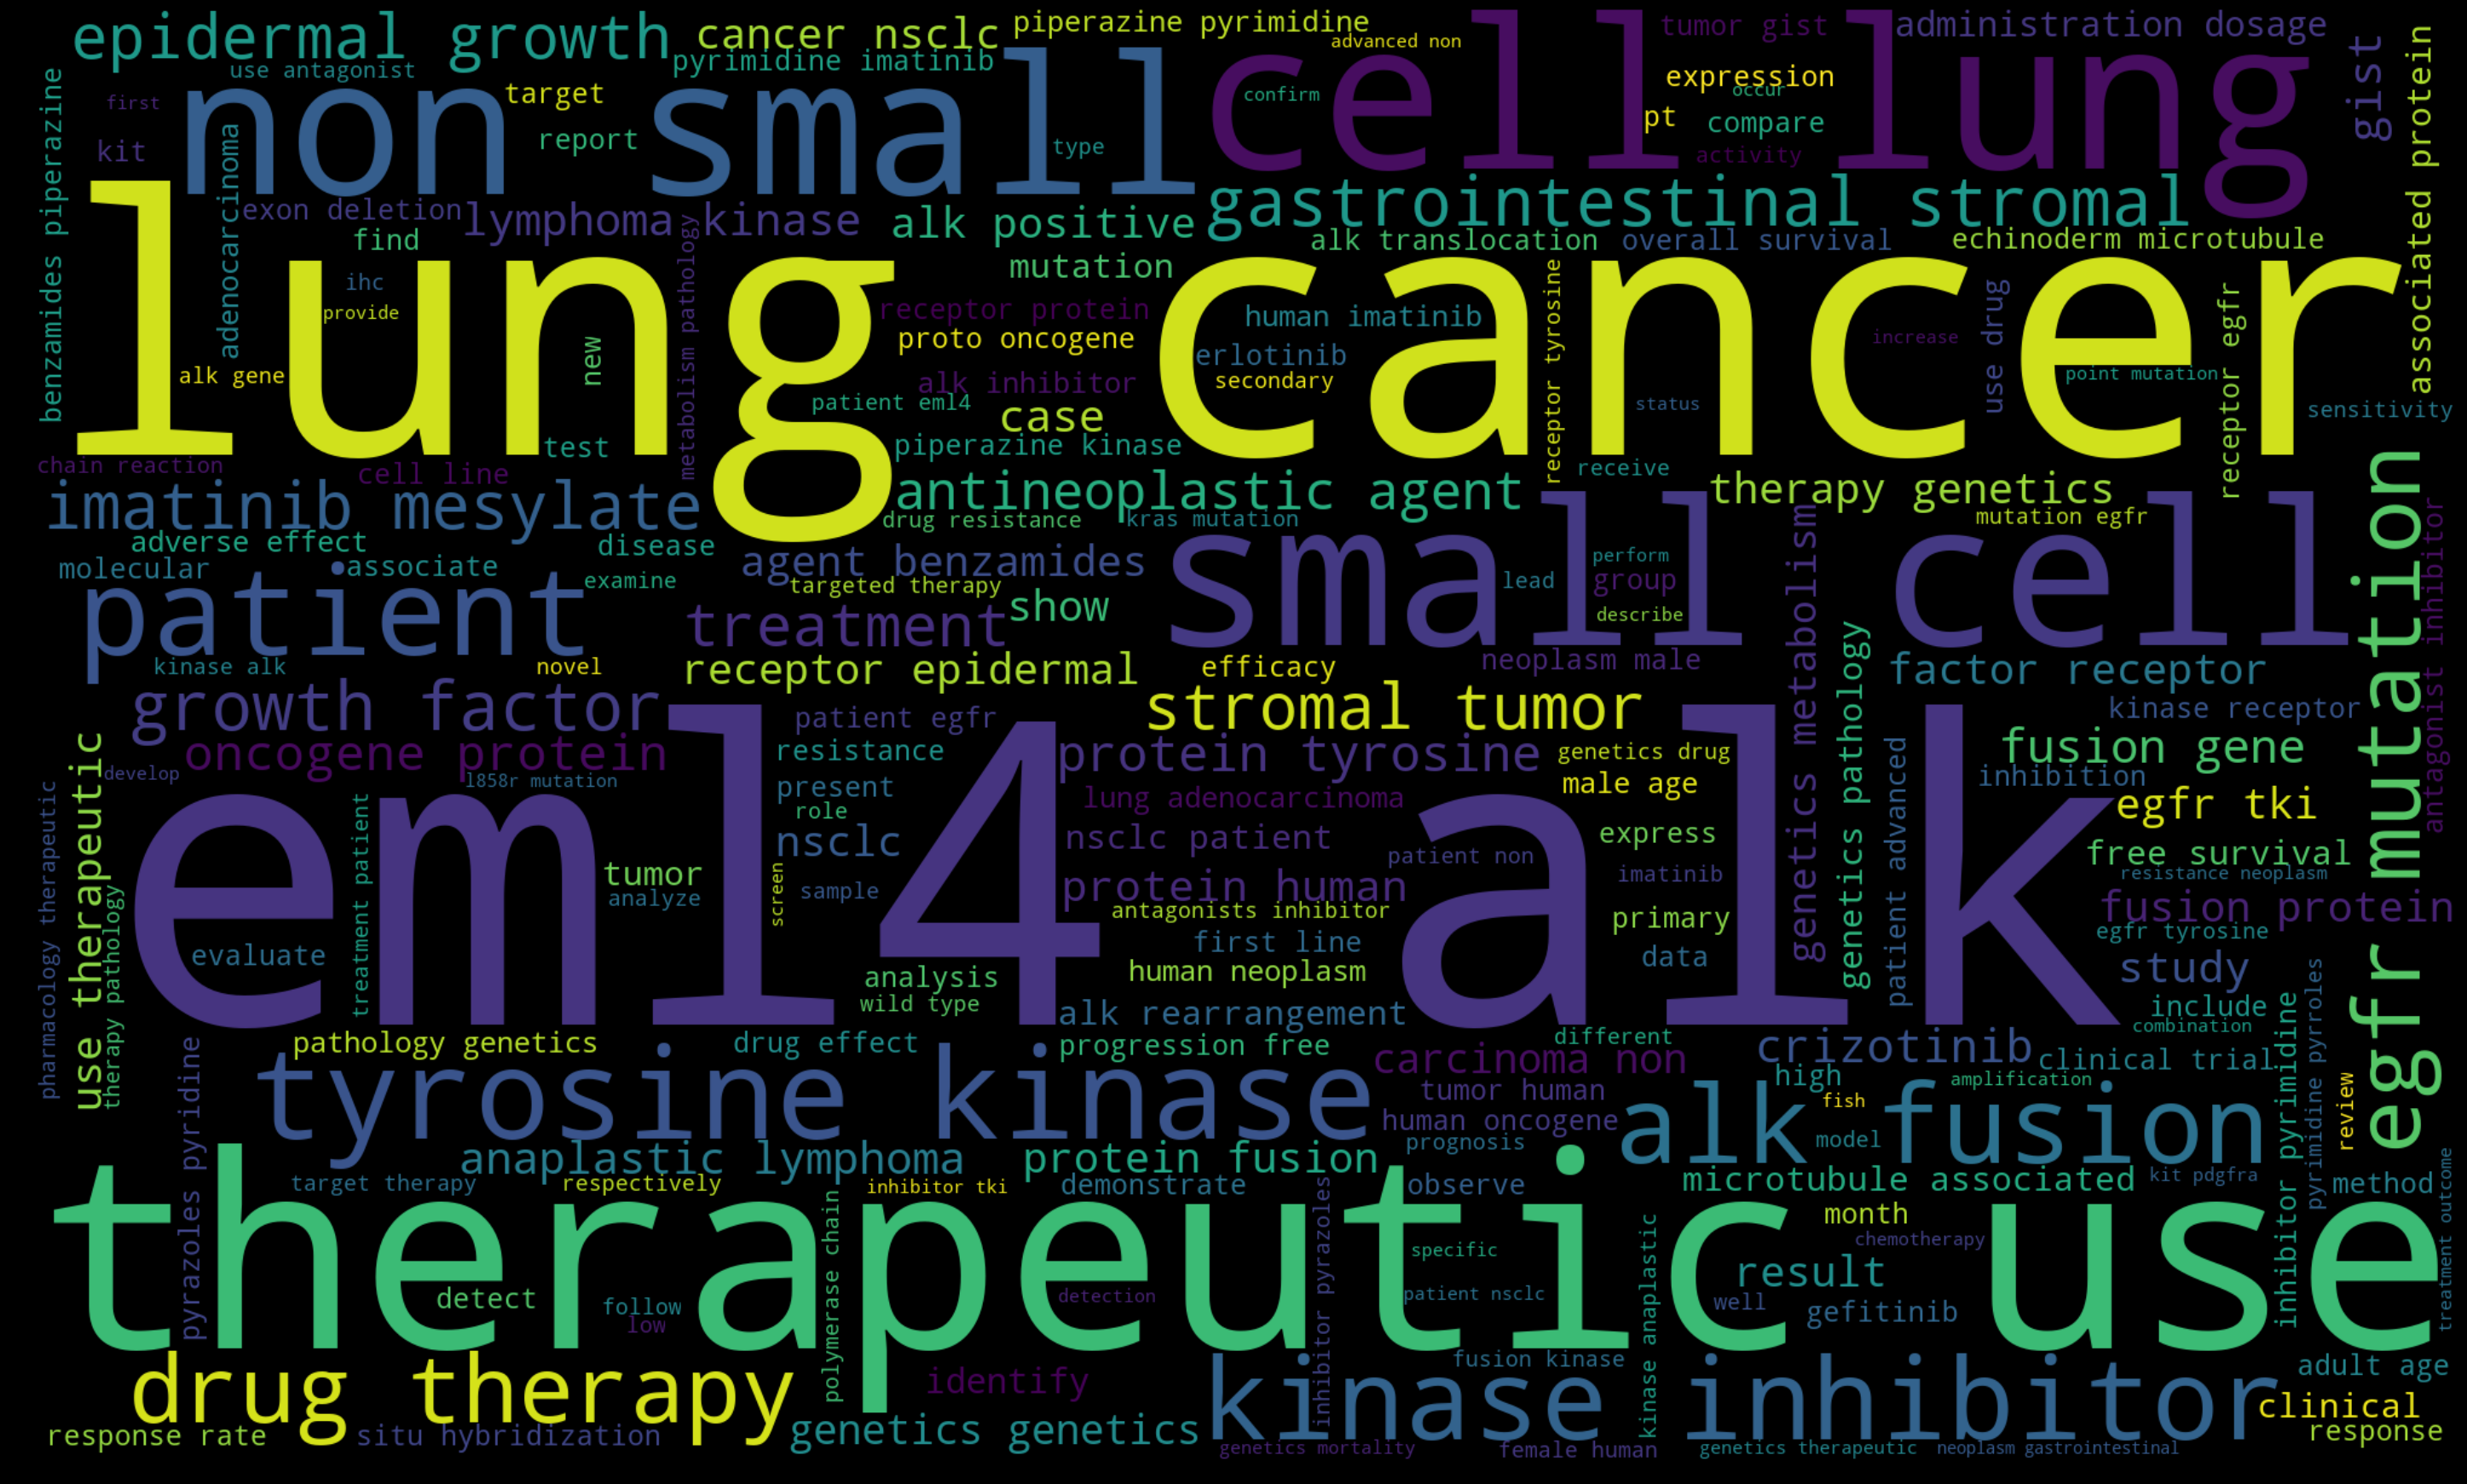

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# get processed text to create word cloud
text = ' '.join(map(str, docs.Processed_Text.values))

# create a word cloud of processed text
wordcloud = WordCloud(width=2000, height=1200, background_color='black').generate(text)

# visualize the word cloud
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Term Frequency Distribution

Term frequency distribution counts the <em><b>occurrence of a word</b></em> (__one-gram__) or words that are adjacent to each other (__n-grams__) in a corpus or a collection of documents. 

- [One-Gram Frequency Distribution](#One-Gram-Frequency-Distribution)
- [Bigrams Frequency Distribution](#Bigrams-Frequency-Distribution)

#### One-Gram Frequency Distribution

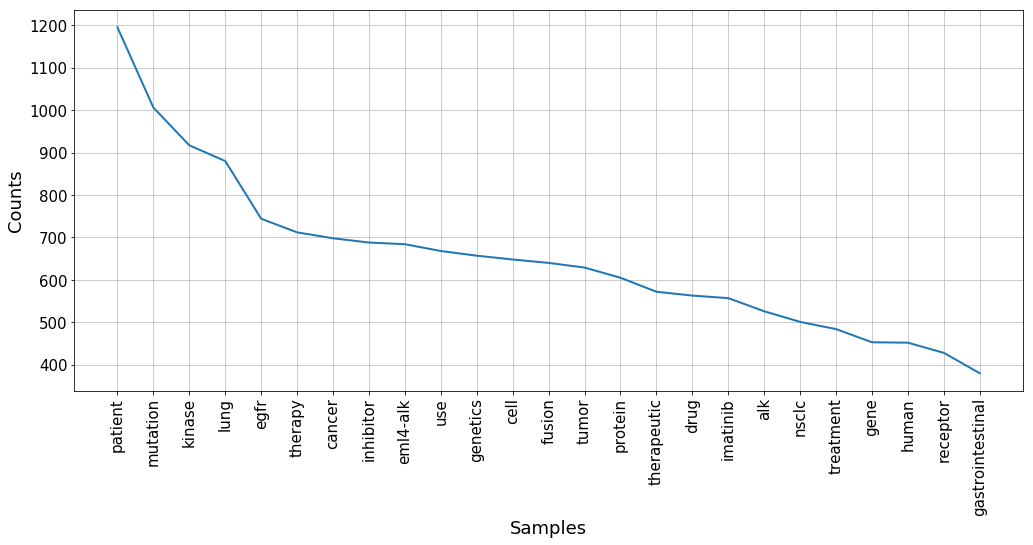

In [6]:
# show one-gram frequency distribution
helpers.plot_freq_dist(text)

#### Bigrams Frequency Distribution

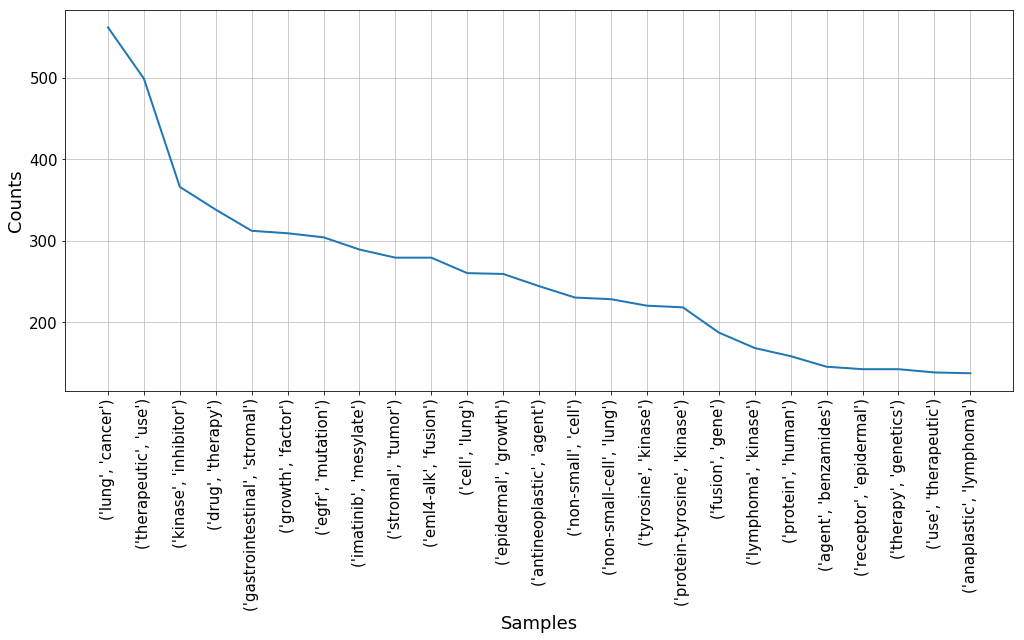

In [7]:
# show bigram frequency distribution
helpers.plot_freq_dist(text, 2)

## Part 4 - Topic Modeling

Topic modeling is an unsupervised machine learning technique that identify co-occurring keywords to summarize large collections of textual information. It helps in discovering hidden topics in the document, annotate the documents with these topics, and organize a large amount of unstructured data.

 - [Latent Dirichlet Allocation](#Latent-Dirichlet-Allocation)
 - [Text Clustering](#Text-Clustering)

In [8]:
# assign name to query topic for ease of information recall
topic_names = {'topic1': 'lung cancer, egfr, aged female',
               'topic2': 'lung cancer, eml4-alk, aged male',
               'topic3': 'gist, kit exon, aged female'}

### Latent Dirichlet Allocation

__Latent Dirichlet Allocation (LDA)__ is a <em>generative probabilistic model</em> of a collection of documents made up of words and/or phrases (n-grams).

 - [LDA Model](#LDA-Model)
 - [LDA Topics](#LDA-Topics)
 - [Documents Ranking on LDA Score](#Documents-Ranking-on-LDA-Score)
 - [Documents Distribution per LDA Score](#Documents-Distribution-per-LDA-Score)
 - [Query Topics Classification](#Query-Topics-Classification)

#### LDA Model

Steps to create LDA model:
 1. Create a sparse matrix of token counts (bag-of-words).
    - __CountVectorizer__
        - Tokenize documents and build the vocabulary of words found in the corpus. Create a sparse matrix of token counts for each document in the corpus.
        - Example:
            - A corpus of two documents
            > ["Dogs love cats.", "Cats hate dogs. Cats love mouses."]
            - Bag-of-words dictionary {word: word's id}
            > {'dogs': 1, 'love': 3, 'cats': 0, 'hate': 2, 'mouses': 4}
            - Convert document 1 to matrix
                - "Dogs love cats." => __[1 1 0 1 0]__
                > <em><b>cats</b></em> occur 1 time => index 0 (or word's id 0) is 1<br />
                  <em><b>dogs</b></em> occur 1 time => index 1 is 1<br />
                  <em><b>hate</b></em> occur 0 time => index 2 is 0<br />
                  <em><b>love</b></em> occur 1 time => index 3 is 1<br />
                  <em><b>mouses</b></em> occur 0 time => index 4 is 0<br />
            - A resulted sparse matrix of tokens counts
            > [[1 1 0 1 0]<br />[2 1 1 1 1]]<br />
 2. Convert sparse matrix to gensim corpus
     - Document 1:
         - "Dogs love cats." => __[(0, 1), (1, 1), (3, 1)]__
         > Word's id <em>0</em> has 1 count => (0, 1)<br />
           Word's id <em>1</em> has 1 count => (1, 1)<br />
           Word's id <em>3</em> has 1 count => (3, 1)
     - A resulted gensim corpus
     > [(0, 1), (1, 1), (3, 1)]<br />
       [(0, 2), (1, 1), (2, 1), (3, 1), (4, 1)]
 3. Create a dictionary that map word's id to word
 > {1: 'dogs', 3: 'love', 0: 'cats', 2: 'hate', 4: 'mouses'}
 4. Find the number of topics for LDA model to come up with topics that are more human intepretable
     - Topic coherence measures how interpretable topics are for human beings.
     - __CoherenceModel__
         - Calculate coherence score for various number of topics for LDA model.
         - Large coherence score indicates the topics are more human-comprehensible.
 5. Create LDA model

In [9]:
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer

# create bag-of-words model
# filter out words that appear < 3% and > 50% of documents
count_vect = CountVectorizer(ngram_range=(1,2), min_df=0.03, max_df=0.5)

# convert text to a sparse matrix of token counts
X = count_vect.fit_transform(docs['Processed_Text'])

# convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

# map word IDs to words (to be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in count_vect.vocabulary_.items())

# find the number of topics for the LDA model to come up with better topics that are more human interpretable
coherent_scores = {}
for num_topics in range(2, 11):
    lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id_map, passes=25, random_state=34)
    cm = CoherenceModel(model=lm, corpus=corpus, coherence='u_mass')
    coherent_scores.update({num_topics: cm.get_coherence()})

# get the optimal number of topics for the LDA model
m_num_topics = max(zip(coherent_scores.values(), coherent_scores.keys()))[1]

# use LdaModel constructor to estimate LDA model parameters on the corpus
lda_model = LdaModel(corpus=corpus, id2word=id_map, passes=25, random_state=34, num_topics=m_num_topics)

C:\Users\Ngoc Phan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


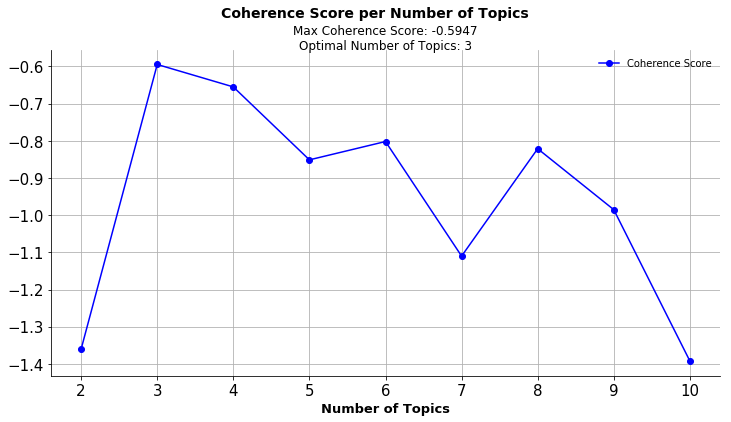

In [10]:
# plot coherence scores
plt.figure(figsize=(12, 6)) # set figure's size
plt.plot(coherent_scores.keys(), coherent_scores.values(), '-bo', label='Coherence Score')

# hide top and right border
_ = [plt.gca().spines[loc].set_visible(False) for loc in ['top', 'right']]

plt.suptitle('Coherence Score per Number of Topics', fontsize=14, fontweight='bold')
plt.title('\nMax Coherence Score: ' + str(round(max(coherent_scores.values()), 4)) +
          '\nOptimal Number of Topics: ' + str(m_num_topics), pad=0.1)
plt.xlabel("Number of Topics", fontsize=13, fontweight='bold')

plt.legend(frameon=False)
plt.grid()
plt.show()

#### LDA Topics

Show the topics identified by LDA Model along with the most significant words sorted by LDA Score.

In [11]:
# get the most significant words for each modeled topic
lda_topics = lda_model.print_topics()

# a dictionary of most significant words for each modeled topic
topic_model_dict = {}
m_topic_labels = ['A','B','C', 'D', 'E', 'F']  # topic's label

# get most significant words and store in a dictionary
for i, t in enumerate(lda_topics):
    words = t[1].split('+')
    term_list = []
    score_list = []
    for w in words:
        w1 = w.split('*')
        term_list.append(w1[1].replace('"', '').strip())
        score_list.append(w1[0])
    topic_model_dict.update({'LDA Topic ' + m_topic_labels[i]: term_list, 
                             'Score_' + m_topic_labels[i]: score_list})

# create the data frame
topic_models = pd.DataFrame(topic_model_dict)

In [12]:
# view modeled topics
topic_models

,LDA Topic A,Score_A,LDA Topic B,Score_B,LDA Topic C,Score_C
0,alk,0.062,imatinib,0.038,egfr,0.050
1,eml4,0.036,gastrointestinal,0.025,egfr mutation,0.017
2,eml4 alk,0.033,therapeutic use,0.023,factor,0.014
3,fusion,0.028,gist,0.021,growth factor,0.014
4,genetics,0.018,stromal,0.021,growth,0.013
5,gene,0.016,gastrointestinal stromal,0.020,epidermal growth,0.013
6,alk fusion,0.015,imatinib mesylate,0.019,epidermal,0.013
7,nsclc,0.013,mesylate,0.019,survival,0.012
8,crizotinib,0.010,stromal tumor,0.018,genetics,0.011
9,positive,0.009,kit,0.018,nsclc,0.011


#### Documents Ranking on LDA Score

Sort documents by LDA Score in descending order and save the result to a file.

In [13]:
lda_results = pd.DataFrame(docs['Document'])    # get document's id
lda_topic_probs = []                            # store class label and probability

# get LDA topic label for each document and probability score
for i, row in enumerate(lda_model[corpus]):
    topic_model, topic_probs = max(row)
    lda_topic_probs.append((m_topic_labels[topic_model], topic_probs))

lda_results['Words in LDA Topic'] = [','.join(topic_model_dict['LDA Topic ' + x[0]]) 
                                           for x in lda_topic_probs]
lda_results['LDA Topic'] = [x[0] for x in lda_topic_probs]            # class label
lda_results['LDA Score'] = [round(x[1], 4) for x in lda_topic_probs]  # probability

# sort documents by LDA score and store the results
sorted_lda_results = lda_results.sort_values(by=['LDA Score'], ascending=False)

# save the ranking to csv file
sorted_lda_results.to_csv('output_files/LDA_Model_Ranking.csv')

In [14]:
# show top 10 documents
sorted_lda_results.head(10)

,Document,Words in LDA Topic,LDA Topic,LDA Score
156,22285168,"egfr,egfr mutation,factor,growth factor,growth...",C,0.9978
140,21415216,"alk,eml4,eml4 alk,fusion,genetics,gene,alk fus...",A,0.9977
69,18166835,"alk,eml4,eml4 alk,fusion,genetics,gene,alk fus...",A,0.9976
166,22613337,"egfr,egfr mutation,factor,growth factor,growth...",C,0.9975
104,19386350,"alk,eml4,eml4 alk,fusion,genetics,gene,alk fus...",A,0.9975
210,24496003,"alk,eml4,eml4 alk,fusion,genetics,gene,alk fus...",A,0.9975
41,16818686,"egfr,egfr mutation,factor,growth factor,growth...",C,0.9974
240,25558790,"egfr,egfr mutation,factor,growth factor,growth...",C,0.9973
199,23769345,"egfr,egfr mutation,factor,growth factor,growth...",C,0.9971
147,21725039,"egfr,egfr mutation,factor,growth factor,growth...",C,0.9971


#### Documents Distribution per LDA Score

Show number of documents per LDA Score range (very low, low, median, high).

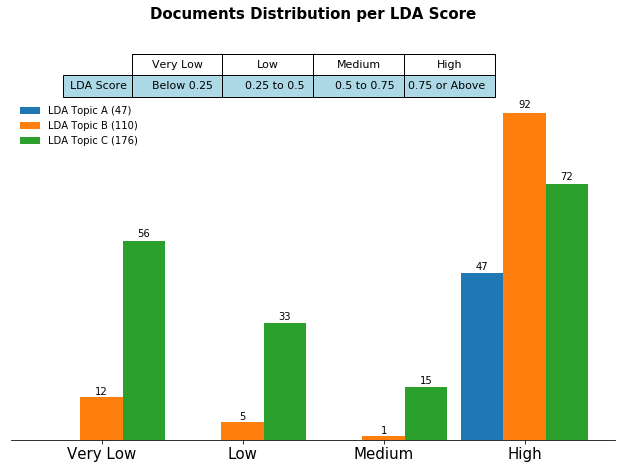

In [15]:
helpers.plot_docs_distribution(lda_results, 'LDA Topic', 'LDA Score', m_num_topics, m_topic_labels,
                               ['LDA Score'], 'Documents Distribution per LDA Score')

##### Query Topics Classification

Classify query topics based on LDA score.

In [16]:
# a dictionary of probability scores for each query topic
topic_prob_dict = {}
lda_topic_probs = []

# get the probability scores for each query topic and store in a dictionary
for i in range(0, topics.shape[0]):
    X_topic = count_vect.fit_transform(
        topics.loc[topics['Topic'] == 'topic' + str(i + 1), 'Processed_Text'].values[0].split(' '))
    corpus_topic = gensim.matutils.Sparse2Corpus(X_topic, documents_columns=False)
    scores = lda_model[corpus_topic[0]]
    topic_prob_dict.update({topic_names['topic'+str(i+1)]: [round(score[1], 4) for score in scores]})
    #print(scores)
    scores_dict = {}
    for index, score in enumerate(scores):
        scores_dict.update({m_topic_labels[index]: round(score[1], 4)})
    lda_topic_probs.append(scores_dict)

# create a data frame that store the probability scores
topic_probs = pd.DataFrame.from_dict(topic_prob_dict, orient='index', 
                                     columns=['LDA Topic ' + x for x in m_topic_labels[0:m_num_topics]])

# view probability scores for query topic
topic_probs

,LDA Topic A,LDA Topic B,LDA Topic C
"lung cancer, egfr, aged female",0.1704,0.6569,0.1727
"lung cancer, eml4-alk, aged male",0.1713,0.1815,0.6473
"gist, kit exon, aged female",0.1803,0.1805,0.6393


In [17]:
# show topic's info such as dominant LDA topic and LDA Score
lda_topic_info = helpers.get_topics_info(m_num_topics, lda_topic_probs, topic_names, 
                                         ['Dominant LDA Topic', 'LDA Score'])
lda_topic_info

,Topic #,Topic Name,Dominant LDA Topic,LDA Score
0,1,"lung cancer, egfr, aged female",B,0.6569
1,2,"lung cancer, eml4-alk, aged male",C,0.6473
2,3,"gist, kit exon, aged female",C,0.6393


### Text Clustering

 - [MiniBatchKMeans Model](#MiniBatchKMeans-Model)
 - [Documents Ranking on Distance to Cluster](#Documents-Ranking-on-Distance-to-Cluster)
 - [Documents Distribution per Distance to Cluster](#Documents-Distribution-per-Distance-to-Cluster)
 - [Cluster Labeling for Query Topics](#Cluster-Labeling-for-Query-Topics)
 - [Model Evaluation](#Model-Evaluation)
    - [Explained Variance Ratio](#Explained-Variance-Ratio)
    - [Sihouette Analysis](#Sihouette-Analysis)

#### MiniBatchKMeans Model

MiniBatchKMeans works similarly to KMeans, but randomly selects sample observations based on batch_size instead of the whole batch. The larger the size of the batch, the more computationally costly the training process.

<em><b>Steps to create a MiniBatchKMeans model</b></em>
1. Convert documents to a matrix of TF-IDF weights
2. Reduce the dimensionality of the dataset
3. Select number of clusters
4. Create MiniBatchKMeans model

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import MiniBatchKMeans

# create bag-of-words of Term Frequency - Inverse Document Frequency weights
# filter out words that appear < 3% and > 50% of documents
tfidf_vect = TfidfVectorizer(use_idf=True, ngram_range=(1,2), min_df=0.03, max_df=0.5)
X_tfidf = tfidf_vect.fit_transform(docs['Processed_Text'])

# use Latent Semantic Analysis (LSA) to reduce the dimensionality of the dataset to 5-D and normalize data
svd = TruncatedSVD(5)                    
normalizer = Normalizer(copy=False)      
lsa = make_pipeline(svd, normalizer)    
X_lsa = lsa.fit_transform(X_tfidf)

# create K-Mean model with 3 number of clusters
num_clusters = 3
km = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, init_size=1000, batch_size=1000,
                        random_state=10)
km.fit(X_lsa)
cluster_labels = km.predict(X_lsa)

In [19]:
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names()

# a dictionary of words in cluster
cluster_dict = {}
cluster_names = ['E', 'F', 'G', 'H', 'I', 'J']

# get all words in each cluster
for i in range(num_clusters):
    term_list = [terms[ind] for ind in order_centroids[i,]]
    cluster_dict.update({'Cluster ' + cluster_names[i]: term_list})

# create a data frame that stores the cluster and its' words
cluster_df = pd.DataFrame(cluster_dict)

# show the top 10 words in cluster
cluster_df.head(10)

,Cluster E,Cluster F,Cluster G
0,alk,imatinib,egfr
1,eml4,gastrointestinal,egfr mutation
2,eml4 alk,gist,gefitinib
3,fusion,stromal,epidermal growth
4,genetics,imatinib mesylate,epidermal
5,alk fusion,mesylate,growth factor
6,nsclc,gastrointestinal stromal,factor
7,crizotinib,therapeutic use,growth
8,gene,stromal tumor,l858r
9,metabolism,kit,exon


#### Documents Ranking on Distance to Cluster

Sort documents on distance to the closest cluster in ascending order and save the results to a csv file.

In [20]:
# get cluster's label for documents
docs_km = pd.DataFrame(docs['Document'])
docs_km['Cluster'] = [cluster_names[c] for c in cluster_labels.tolist()]
docs_km['Words in Cluster'] = [', '.join(cluster_dict['Cluster ' + cluster_names[c]]) for c in cluster_labels]

# get all distances to all clusters
km_distances = km.fit_transform(X_lsa)         

# get the minimum distance (distance to the closest cluster)
docs_km['Distance to Cluster'] = np.min(km_distances, axis=1) 

# sort documents by Distance to Cluster in ascending order
sorted_km_results = docs_km.sort_values(by=['Distance to Cluster'], ascending=True)

# save to csv file
sorted_km_results.to_csv('output_files/KMeans_Ranking.csv')

# view the ranking
sorted_km_results.head(10)

,Document,Cluster,Words in Cluster,Distance to Cluster
324,ASCO_191981-199,G,"egfr, egfr mutation, gefitinib, epidermal grow...",0.073968
84,18509184,G,"egfr, egfr mutation, gefitinib, epidermal grow...",0.102580
285,26798590,E,"alk, eml4, eml4 alk, fusion, genetics, alk fus...",0.103047
36,16503086,G,"egfr, egfr mutation, gefitinib, epidermal grow...",0.104387
48,17196360,F,"imatinib, gastrointestinal, gist, stromal, ima...",0.109009
60,17661208,F,"imatinib, gastrointestinal, gist, stromal, ima...",0.114691
148,21757253,E,"alk, eml4, eml4 alk, fusion, genetics, alk fus...",0.116605
153,22119437,G,"egfr, egfr mutation, gefitinib, epidermal grow...",0.116912
313,AACR_2016-269,G,"egfr, egfr mutation, gefitinib, epidermal grow...",0.121844
317,ASCO_129081-144,G,"egfr, egfr mutation, gefitinib, epidermal grow...",0.123629


#### Documents Distribution per Distance to Cluster

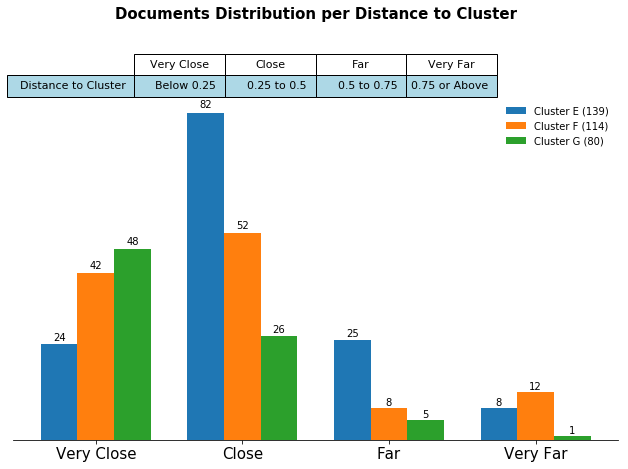

In [21]:
helpers.plot_docs_distribution(sorted_km_results, 'Cluster', 'Distance to Cluster', num_clusters, cluster_names,
                               ['Distance to Cluster'], 'Documents Distribution per Distance to Cluster',
                               width=0.25, 
                               bin_labels=['Very Close','Close', 'Far', 'Very Far'])

<em><b>*** Distance to Cluster </b></em> means the distance between the document and the closest cluster.

#### Cluster Labeling for Query Topics

Classify query topics according to the distance to closest cluster.

In [22]:
X_lsa_topics = []    # extracted features for query topics
topic_labels = []    # cluster labels for query topics
topic_dist = []      # store the distance to cluster

# extract features and get predicted cluster labels for query topics
for i in range(0, topics.shape[0]):
    X_lsa_topics.append(lsa.fit_transform(tfidf_vect.fit_transform(
        topics.loc[topics['Topic'] == 'topic' + str(i + 1), 'Processed_Text'].values[0].split(' '))))
    topic_labels.append(km.predict(X_lsa_topics[i]))      # predicted cluster labels
    
    # get all distances to all clusters
    km_dist = km.fit_transform(X_lsa_topics[i])   

    # get the minimum distance to closest cluster 
    min_dist = np.min(km_dist, axis=1)    
   
    # store the minimum distance for each feature
    c_dict = {}
    for index, c_label in enumerate(topic_labels[i]):
        if c_label not in c_dict:
            c_dict.update({c_label: [min_dist[index]]})
        else:
            c_dict[c_label].append(min_dist[index])
    
    # get the median minimum-distance for each class label
    avg_dist = {}
    for key in c_dict:
        avg_dist.update({cluster_names[key]: round(np.median(np.sort(c_dict[key])), 3)})
    topic_dist.append(avg_dist)

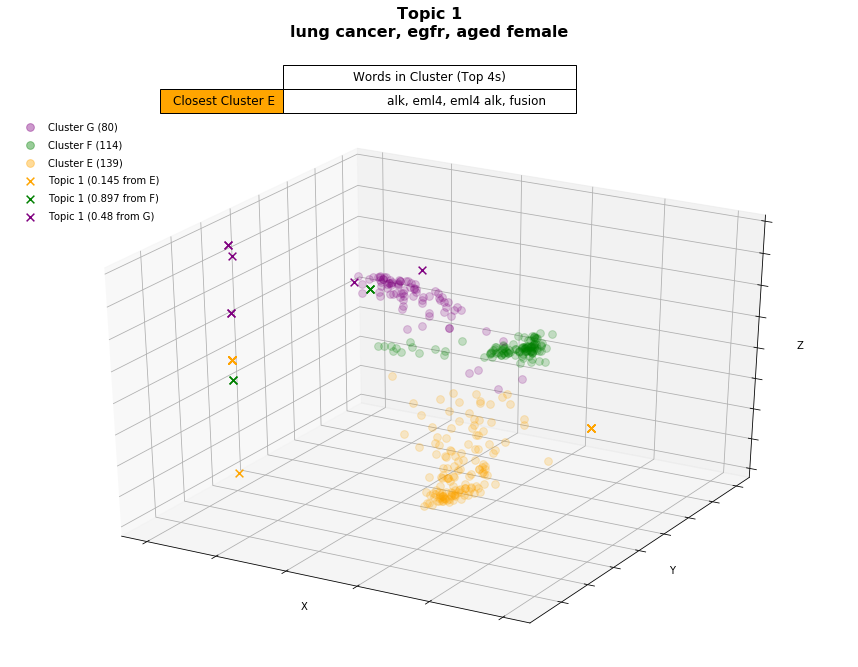

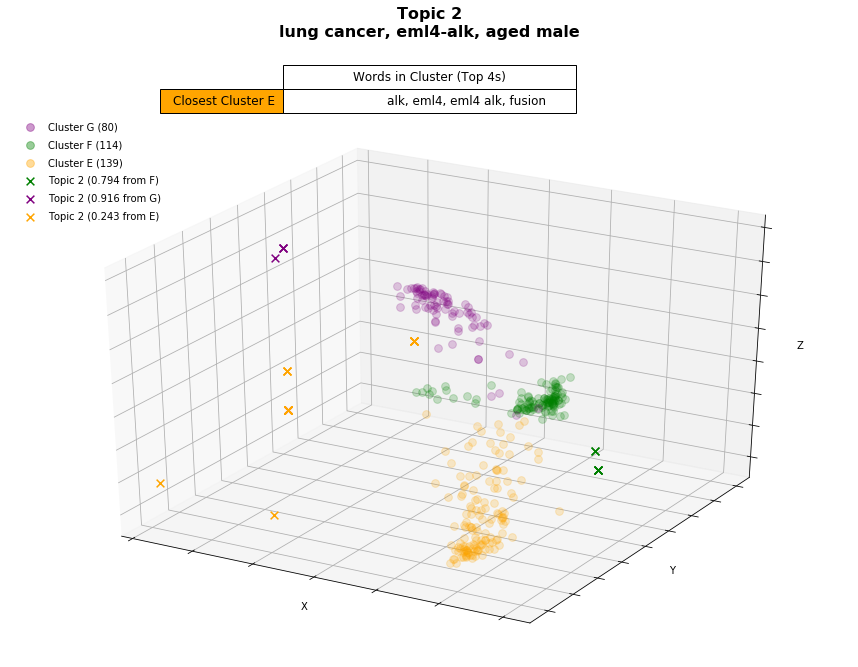

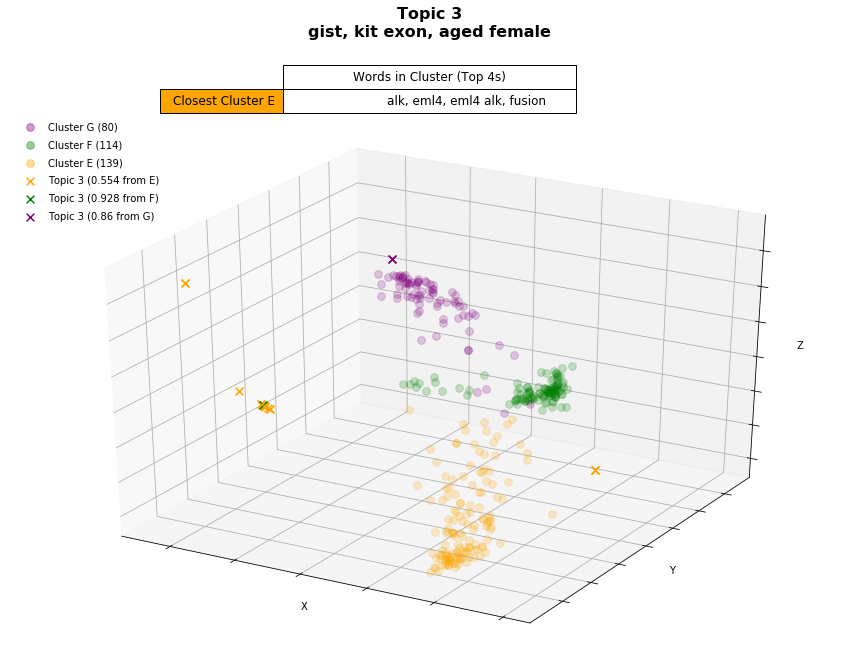

In [23]:
# plot the clusters and query topics
for i in range(0, topics.shape[0]):
    helpers.plot_clusters_3D(X_lsa, cluster_labels, X_lsa_topics, cluster_names, topic_labels, 
           topic_dist[i], topic_names, cluster_dict, i)

#### Model Evaluation

- [Explained Variance Ratio](#Explained-Variance-Ratio)
- [Sihouette Analysis](#Sihouette-Analysis)

##### Explained Variance Ratio

The explained variance ratio indicates the proportion of the dataset's variance that lies along the axis of each principal component.

In [24]:
# show the explained variance for the first five components of the dataset
ax_list = []
var_list = []
ax_names = ['first', 'second', 'third', 'fourth', 'fifth']
for i, v in enumerate(svd.explained_variance_ratio_):
    ax_list.append(ax_names[i])
    var_list.append(round(v*100,2))

# store explained variance for each principal component in a data frame
evr_df =  pd.DataFrame()
evr_df['Axis'] = ax_list
evr_df['Dataset\'s Variance (%)'] = var_list

# view explained variance
evr_df

,Axis,Dataset's Variance (%)
0,first,10.34
1,second,10.03
2,third,8.46
3,fourth,6.46
4,fifth,4.86


##### Sihouette Analysis

Study the separation distance between the resulting clusters.
      
<b>Silhouette coefficients</b>
    - Values range between -1 and 1
    - Closed to +1 => the sample is far away from the neighboring clusters.
    - Closed to 0 => the sample is on or very close to the decision boundary between two neighboring clusters.
    - Negative => the samples might have been assigned to the wrong cluster.

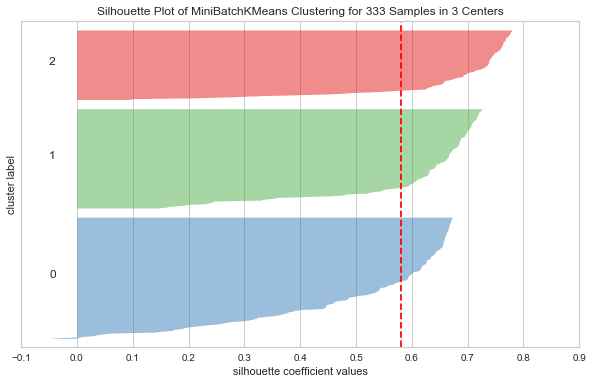

In [25]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(10, 6))
visualizer = SilhouetteVisualizer(km)   # Instantiate the clustering model and visualizer
visualizer.fit(X_lsa)                   # Fit the training data to the visualizer
visualizer.poof()                       # Draw/show/poof the data

<em><b>Silhouette Plot Analysis</b></em>

- Cluster E is labeled as cluster 0 on the plot.
- Cluster F is labeled as cluster 1.
- Cluster G is labeled as cluster 2.
- The vertical red dashed line indicate the average silhouette score.
- The silhouette scores for three cluster are all above the average silhouette score.
- The size of the cluster indicates that cluster E (labeled 0) has the most number of observations, and cluster G (labeled 2) has the least number of observations.
- Cluster E (labeled 0) has some samples with negavie silhouette score, which indicates that those samples shouldn't be assigned to cluster E.

## Part 5 - Semantic Similarity

Measures the likeness that the two documents have similar meaning (semantic content).

<em><b>Steps to compute semantic similarity</b></em>
1. Perform part-of-speech tagging on the documents
2. Convert documents to synsets
3. Compute similarity score using the synsets of the two documents
4. Compute the symmetrical similarity between documents

In [26]:
# create synsets for each topic
topic_synsets = {}
for key in helpers.topic_pos:
    topic_synsets.update({key: helpers.doc_to_synsets(helpers.topic_pos[key])})

# compute similarity score for documents and each topic
for key in topic_synsets:
    docs['Similarity_' + key] = docs['Document'].apply(lambda x: 
                                                       helpers.document_path_similarity(x, topic_synsets[key]))

In [27]:
docs[['Document', 'Similarity_topic1', 'Similarity_topic2', 'Similarity_topic3']].head(10)

,Document,Similarity_topic1,Similarity_topic2,Similarity_topic3
0,11510027,0.423694,0.351040,0.318096
1,11572056,0.379869,0.409986,0.464460
2,11760588,0.364611,0.407324,0.476476
3,12174137,0.284002,0.371541,0.493954
4,12389876,0.397958,0.362464,0.479863
5,12392638,0.259577,0.288023,0.486162
6,12394270,0.360478,0.397535,0.494249
7,12783584,0.280399,0.316804,0.487710
8,12867061,0.566778,0.425141,0.415336
9,12897659,0.353858,0.325636,0.549472


In [28]:
docs.describe()

,Similarity_topic1,Similarity_topic2,Similarity_topic3
count,333.000000,333.000000,333.000000
mean,0.435823,0.440598,0.406055
std,0.103753,0.093732,0.090233
min,0.225741,0.216693,0.170221
25%,0.352020,0.362464,0.344211
50%,0.435216,0.447802,0.411921
75%,0.516944,0.513469,0.465123
max,0.638630,0.648084,0.606910


In [29]:
# sort documents by Similarity Score in descending order and save the results to csv file
for i in range(topics.shape[0]):
    docs[['Document', 'Similarity_topic' + str(i+1)]].sort_values(by=['Similarity_topic' + str(i+1)], 
                            ascending=False).to_csv('output_files/Semantic_Similarity_Topic' + str(i+1) + '.csv')